In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns


from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD
import warnings
warnings.filterwarnings("ignore")


import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [3]:
Ravdess = "D:/PYTHON/Speech_Emotion_recognition/audio_speech_actors_01-24/"

In [4]:

from glob import glob # allows us to list all files to a directory

import librosa # main package for working with Audio Data
import librosa.display

import IPython.display as ipd # to play the Audio Files
from itertools import cycle

In [5]:
ravdess_directory_list = os.listdir(Ravdess)

emotion_df = []

for dir in ravdess_directory_list:
    actor = os.listdir(os.path.join(Ravdess, dir))
    for wav in actor:
        info = wav.partition(".wav")[0].split("-")
        emotion = int(info[2])
        emotion_df.append((emotion, os.path.join(Ravdess, dir, wav)))

In [6]:
Ravdess_df = pd.DataFrame.from_dict(emotion_df)
Ravdess_df.rename(columns={1 : "Path", 0 : "Emotion"}, inplace=True)

In [7]:
Ravdess_df.Emotion.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()

,Emotion,Path
0,neutral,D:/PYTHON/Speech_Emotion_recognition/audio_spe...
1,neutral,D:/PYTHON/Speech_Emotion_recognition/audio_spe...
2,neutral,D:/PYTHON/Speech_Emotion_recognition/audio_spe...
3,neutral,D:/PYTHON/Speech_Emotion_recognition/audio_spe...
4,neutral,D:/PYTHON/Speech_Emotion_recognition/audio_spe...


In [8]:
# Let's concat all datasets together for doing some analysis
df = pd.concat([Ravdess_df], axis=0)
df.shape

(1440, 2)

In [9]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title(f'Waveplot for audio with {e} emotion', size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

In [10]:
def noise(data, random=False, rate=0.035, threshold=0.075):
    """Add some noise to sound sample. Use random if you want to add random noise with some threshold.
    Or use rate Random=False and rate for always adding fixed noise."""
    if random:
        rate = np.random.random() * threshold
    noise_amp = rate*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    """Stretching data with some rate."""
    return librosa.effects.time_stretch(data, rate)

def shift(data, rate=1000):
    """Shifting data with some rate"""
    shift_range = int(np.random.uniform(low=-5, high = 5)*rate)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    
    return librosa.effects.pitch_shift(data, sr = sampling_rate, n_steps = pitch_factor)

In [11]:
n_fft = 2048
hop_length = 512

In [12]:
def chunks(data, frame_length, hop_length):
    for i in range(0, len(data), hop_length):
        yield data[i:i+frame_length]

# Zero Crossing Rate
def zcr(data, frame_length=2048, hop_length=512):
    zcr = librosa.feature.zero_crossing_rate(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)


def energy(data, frame_length=2048, hop_length=512):
    en = np.array([np.sum(np.power(np.abs(data[hop:hop+frame_length]), 2)) for hop in range(0, data.shape[0], hop_length)])
    return en / frame_length


def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)


def entropy_of_energy(data, frame_length=2048, hop_length=512):
    energies = energy(data, frame_length, hop_length)
    energies /= np.sum(energies)

    entropy = 0.0
    entropy -= energies * np.log2(energies)
    return entropy


def spc(data, sr, frame_length=2048, hop_length=512):
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spectral_centroid)


# def spc_entropy(data, sr):
#     spc_en = spectral_entropy(data, sf=sr, method="fft")
#     return spc_en

def spc_flux(data):
    isSpectrum = data.ndim == 1
    if isSpectrum:
        data = np.expand_dims(data, axis=1)

    X = np.c_[data[:, 0], data]
    af_Delta_X = np.diff(X, 1, axis=1)
    vsf = np.sqrt((np.power(af_Delta_X, 2).sum(axis=0))) / X.shape[0]

    return np.squeeze(vsf) if isSpectrum else vsf


def spc_rollof(data, sr, frame_length=2048, hop_length=512):
    spcrollof = librosa.feature.spectral_rolloff(y=data, sr=sr, n_fft=frame_length, hop_length=hop_length)
    return np.squeeze(spcrollof)


def chroma_stft(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    stft = np.abs(librosa.stft(data))
    chroma_stft = librosa.feature.chroma_stft(S=stft, sr=sr)
    return np.squeeze(chroma_stft.T) if not flatten else np.ravel(chroma_stft.T)


def mel_spc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mel = librosa.feature.melspectrogram(y=data, sr=sr)
    return np.squeeze(mel.T) if not flatten else np.ravel(mel.T)

def mfcc(data, sr, frame_length=2048, hop_length=512, flatten: bool = True):
    mfcc_feature = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc_feature.T) if not flatten else np.ravel(mfcc_feature.T)

In [13]:
path = np.array(df["Path"])[658]
data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
len(data)

54458

In [14]:
def extract_features(data, sr, frame_length=2048, hop_length=512):
    result = np.array([])
    result = np.hstack((result,
                        #zcr(data, frame_length, hop_length),
                        # np.mean(energy(data, frame_length, hop_length),axis=0),
                        # np.mean(entropy_of_energy(data, frame_length, hop_length), axis=0),
                        #rmse(data, frame_length, hop_length),
                        # spc(data, sr, frame_length, hop_length),
                        # spc_entropy(data, sr),
                        # spc_flux(data),
                        # spc_rollof(data, sr, frame_length, hop_length),
                        # chroma_stft(data, sr, frame_length, hop_length),
                        # mel_spc(data, sr, frame_length, hop_length, flatten=True)
                        mfcc(data, sr, frame_length, hop_length)
                                    ))
    return result

In [15]:
def get_features(path, duration=2.5, offset=0.6):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=duration, offset=offset)

     # without augmentation
    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    # data with noise
    noise_data = noise(data, random=True)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2)) # stacking vertically

    # data with pitching
    pitched_data = pitch(data, sample_rate)
    res3 = extract_features(pitched_data, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    # data with pitching and white_noise
    new_data = pitch(data, sample_rate)
    data_noise_pitch = noise(new_data, random=True)
    res3 = extract_features(data_noise_pitch, sample_rate)
    result = np.vstack((result, res3)) # stacking vertically

    return result


In [16]:
X, Y = [], []
print("Feature processing...")
for path, emotion, ind in zip(df.Path, df.Emotion, range(df.Path.shape[0])):
    features = get_features(path)
    if ind % 100 == 0:
        print(f"{ind} samples has been processed...")
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
print("Done.")

Feature processing...
0 samples has been processed...
100 samples has been processed...
200 samples has been processed...
300 samples has been processed...
400 samples has been processed...
500 samples has been processed...
600 samples has been processed...
700 samples has been processed...
800 samples has been processed...
900 samples has been processed...
1000 samples has been processed...
1100 samples has been processed...
1200 samples has been processed...
1300 samples has been processed...
1400 samples has been processed...
Done.


In [17]:
features_path = "./features_usml.csv"

In [18]:
extracted_df = pd.DataFrame(X)
extracted_df["labels"] = Y
extracted_df.drop(['labels'], axis=1,inplace=True)

In [19]:
# Fill NaN with 0
extracted_df = extracted_df.fillna(0)
print(extracted_df.isna().any())
extracted_df.shape

0       False
1       False
2       False
3       False
4       False
        ...  
2155    False
2156    False
2157    False
2158    False
2159    False
Length: 2160, dtype: bool


(5760, 2160)

In [20]:
extracted_df.to_csv(features_path, index=False)
extracted_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159
0,-856.323669,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.776301,0.766315,0.755441,0.743671,0.731043,0.717561,0.703260,0.688124,0.672208,0.655518
1,-536.383582,-6.691190,0.486546,-6.197273,1.762231,-1.444799,-0.966865,-2.635430,-2.296796,2.386176,...,1.135756,-1.591379,-1.877080,4.343983,8.590272,0.029719,-4.494253,-3.138401,-1.065086,1.282377
2,-904.339050,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.006816,0.006713,0.006601,0.006483,0.006356,0.006218,0.006066,0.005919,0.005759,0.005588
3,-794.183269,-8.959585,-1.820238,3.519783,2.526391,6.882447,-0.600735,-7.364251,-1.875337,10.810973,...,-0.615389,-0.971162,-1.554828,-1.229298,-2.219572,-1.695649,-2.158863,2.286437,2.776777,1.257374
4,-859.724792,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
# can use this directly from saved feature .csv file
Emotions = pd.read_csv('./features_usml.csv')
Emotions.head()
Emotions.shape

(5760, 2160)

#DATA PREPROCESSING

In [22]:
X = Emotions.iloc[: ,:].values
Emotions.iloc[: ,:].columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '2150', '2151', '2152', '2153', '2154', '2155', '2156', '2157', '2158',
       '2159'],
      dtype='object', length=2160)

In [23]:
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(X), columns = Emotions.iloc[: ,:].columns)
scaled_df.head()

,0,1,2,3,4,5,6,7,8,9,...,2150,2151,2152,2153,2154,2155,2156,2157,2158,2159
0,-1.177971,-0.240056,-0.001332,-0.446562,-0.356093,-0.189218,0.063213,0.137067,-0.153756,-0.313120,...,0.017549,0.147764,0.009662,0.001416,0.094358,0.091430,0.159378,0.135916,0.155344,0.157356
1,0.562944,-0.622213,0.036183,-1.090935,-0.107618,-0.392378,-0.058197,-0.192445,-0.561677,0.098815,...,0.073445,-0.248706,-0.468069,0.681872,1.505013,-0.034839,-0.843681,-0.653215,-0.194210,0.289843
2,-1.439240,-0.240056,-0.001332,-0.446562,-0.356093,-0.189218,0.063213,0.137067,-0.153756,-0.313120,...,-0.102109,0.020029,-0.126232,-0.137912,-0.035717,-0.039153,0.024827,-0.004773,0.021250,0.019993
3,-0.839841,-0.751769,-0.141681,-0.080586,0.000129,0.778555,-0.012221,-0.783698,-0.486824,1.553222,...,-0.198865,-0.144411,-0.409589,-0.371474,-0.435249,-0.351567,-0.392978,0.465531,0.578797,0.284559
4,-1.196477,-0.240056,-0.001332,-0.446562,-0.356093,-0.189218,0.063213,0.137067,-0.153756,-0.313120,...,-0.103169,0.018900,-0.127430,-0.139138,-0.036857,-0.040294,0.023657,-0.005993,0.020092,0.018811


In [24]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
pca_df = pd.DataFrame(pca.fit_transform(scaled_df), columns = ['PCA1','PCA2','PCA3'])
pca_df

,PCA1,PCA2,PCA3
0,-21.325277,-8.536653,0.774962
1,-2.604394,-12.572803,-5.614279
2,-21.961822,-4.194392,0.282239
3,-15.123402,-4.639972,-1.953020
4,-19.258896,-5.296721,1.207280
...,...,...,...
5755,11.792443,-9.973472,6.144645
5756,4.025792,-1.128588,19.073642
5757,11.275868,-14.814064,0.794815
5758,5.066071,-0.259497,22.925983


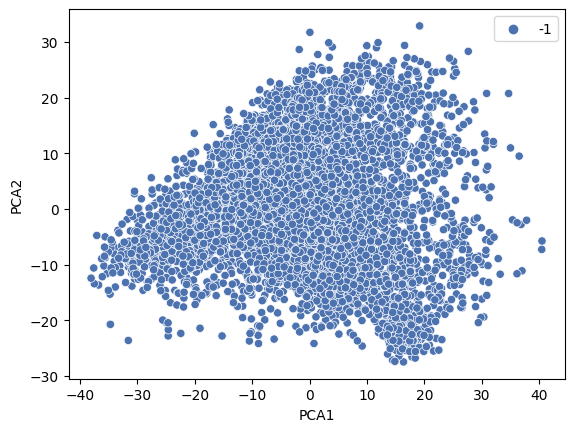

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [26]:
# 2D
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
dbscan = DBSCAN()
dbscan.fit(pca_df)
sns.scatterplot(data = pca_df, x="PCA1",y="PCA2",hue=dbscan.labels_,legend="full",palette="deep")
plt.show()
# sns.move_legend(p, "upper right", bbox_to_anchor = (1., 1.), title = 'DBSCAN Clusters')
print("Silhoutte Score for DBSCAN is:", silhouette_score(pca_df[['PCA1','PCA2']], dbscan.labels_))

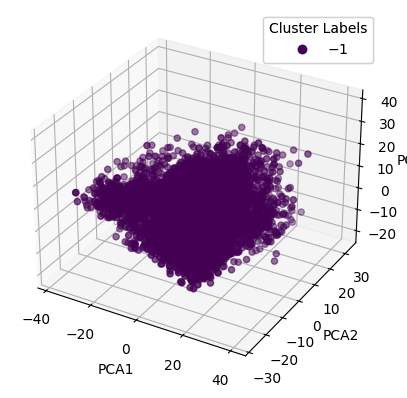

In [27]:
# 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df['PCA1'], pca_df['PCA2'], pca_df['PCA3'], c=dbscan.labels_)
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')
legend = ax.legend(*scatter.legend_elements(), title='Cluster Labels')
ax.add_artist(legend)
plt.show()

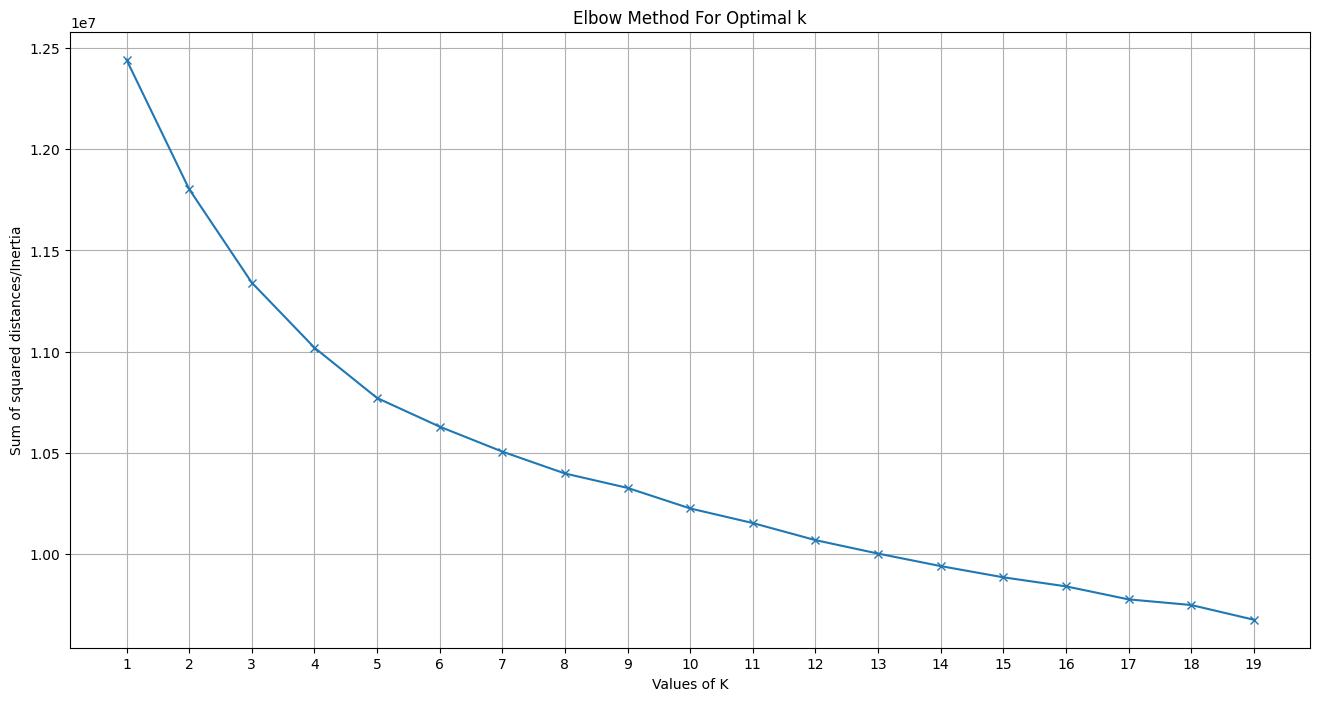

In [28]:
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,20)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(scaled_df)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.figure(figsize = (16, 8))
plt.plot(K,Sum_of_squared_distances,'x-')
plt.xlabel('Values of K') 
plt.xticks(np.arange(1, 20, 1))
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.grid()
plt.show()

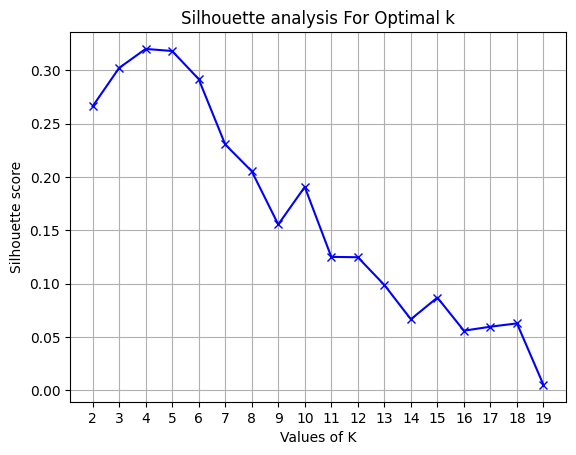

In [29]:
range_n_clusters = np.arange(2, 20, 1)
silhouette_avg = []
for num_clusters in range_n_clusters:
 
 # initialise kmeans
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(scaled_df)
 cluster_labels = kmeans.labels_
 
 # silhouette score
 silhouette_avg.append(silhouette_score(pca_df, cluster_labels))

plt.plot(range_n_clusters,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.xticks(range_n_clusters)
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.grid()
plt.show()

1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'

In [30]:
import numpy as np

# Define a dictionary mapping the numbers to the corresponding string labels
label_map = {
     
    0: "neutral",                            
    1: "happy",
    2: "sad",            
    3: "angry",
    4: "fear",
    5: "disgust",
    6: "surprise"
}

# # Convert the labels from numbers to strings using the label_map
# string_labels = [label_map[label] for label in km.labels_]

# # Print the string labels
# print(string_labels)

Silhoutte Score for K Means is: 0.2385738333564395


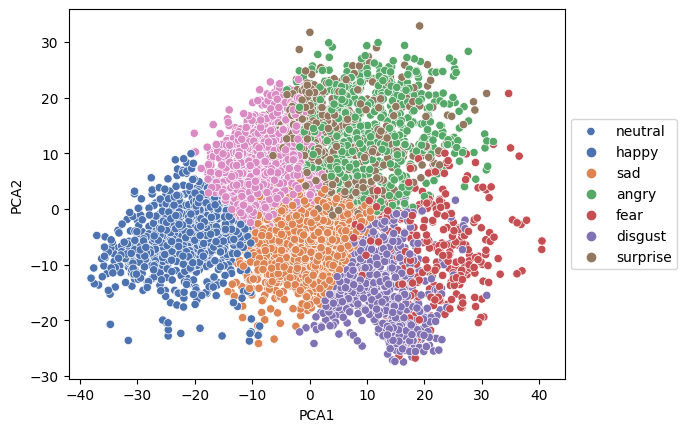

In [31]:
# 2D
km = KMeans(n_clusters = 7)
km.fit(pca_df)

mapped_labels = np.array([list(label_map.values())[i] for i in np.searchsorted(np.unique(km.labels_), km.labels_)])

sns.scatterplot(data = pca_df, x="PCA1",y="PCA2",hue=km.labels_,legend="full",palette="deep")
# sns.move_legend(p, "upper right", bbox_to_anchor = (1., 1.), title = 'K Means Clusters')
plt.legend(label_map.values(),loc='center left', bbox_to_anchor=(1, 0.5))
print("Silhoutte Score for K Means is:", silhouette_score(pca_df[['PCA1','PCA2']], km.labels_))

In [32]:
labels = km.labels_

Silhouette Score for KMeans is: 0.2964360769901333


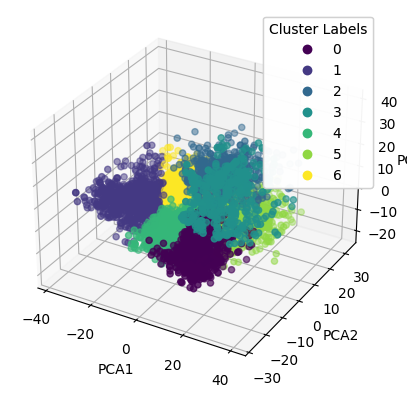

In [33]:
# 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Create a KMeans object with 16 clusters and fit to PCA data
km = KMeans(n_clusters=7)
km.fit(pca_df)

# Create a new 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the PCA data, color-coded by cluster label
scatter = ax.scatter(pca_df['PCA1'], pca_df['PCA2'], pca_df['PCA3'], c=km.labels_)

# Set x, y, and z axis labels
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

# Create a legend for the cluster labels
legend = ax.legend(*scatter.legend_elements(), title='Cluster Labels')
ax.add_artist(legend)

# Calculate and print the Silhouette score
print("Silhouette Score for KMeans is:", silhouette_score(pca_df[['PCA1','PCA2','PCA3']], km.labels_))

# Show the plot
plt.show()


In [34]:
import numpy as np

# Define a dictionary mapping the numbers to the corresponding string labels
label_map = {
     
    0: "neutral",                            
    1: "happy",
    2: "sad",            
    3: "angry",
    4: "fear",
    5: "disgust",
    6: "surprise"
}

# # Convert the labels from numbers to strings using the label_map
# string_labels = [label_map[label] for label in km.labels_]

# # Print the string labels
# print(string_labels)

Silhoutte Score for Agglomerative Clustering is: 0.1667759888396631


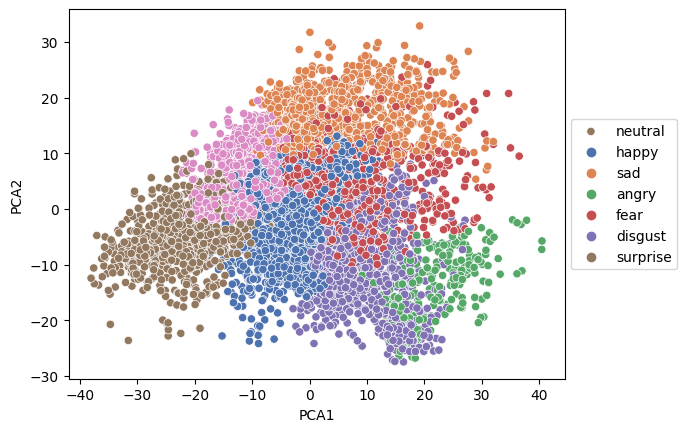

In [35]:
# 2D
from sklearn.cluster import AgglomerativeClustering
ag = AgglomerativeClustering(n_clusters=7)
ag.fit(pca_df)
sns.scatterplot(data = pca_df, x="PCA1",y="PCA2",hue=ag.labels_,legend="full",palette="deep")
plt.legend(label_map.values(),loc='center left', bbox_to_anchor=(1, 0.5))
# sns.move_legend(p, "upper right", bbox_to_anchor = (1., 1.), title = 'Agglomerative Clusters')
print("Silhoutte Score for Agglomerative Clustering is:", silhouette_score(pca_df[['PCA1','PCA2']], ag.labels_))

Silhouette Score for Agglomerative Clustering is: 0.21907426277895917


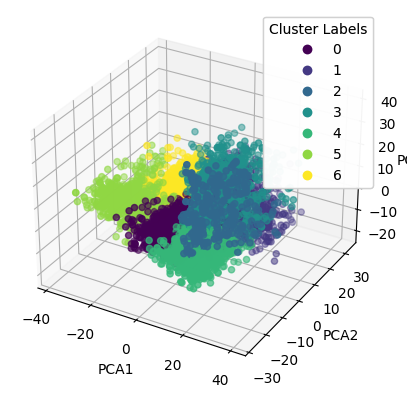

In [36]:
# 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Create an Agglomerative Clustering object with 16 clusters and fit to PCA data
ag = AgglomerativeClustering(n_clusters=7)
ag.fit(pca_df)

# Create a new 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the PCA data, color-coded by cluster label
scatter = ax.scatter(pca_df['PCA1'], pca_df['PCA2'], pca_df['PCA3'], c=ag.labels_)

# Set x, y, and z axis labels
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

# Create a legend for the cluster labels
legend = ax.legend(*scatter.legend_elements(), title='Cluster Labels')
ax.add_artist(legend)

# Calculate and print the Silhouette score
print("Silhouette Score for Agglomerative Clustering is:", silhouette_score(pca_df[['PCA1','PCA2','PCA3']], ag.labels_))

# Show the plot
plt.show()

Silhoutte Score for Birch is: 0.2019126252063401


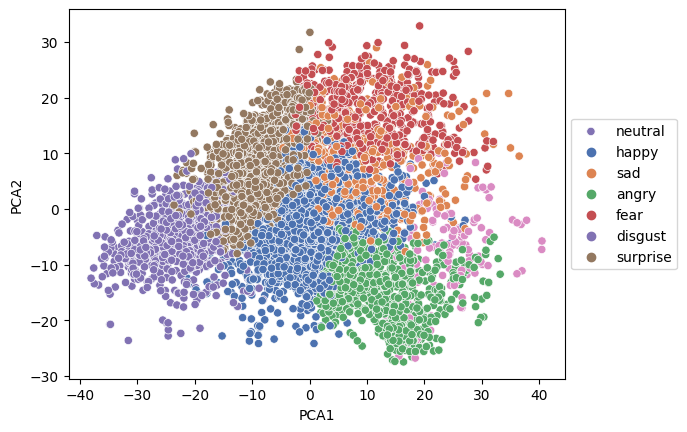

In [37]:
# 2D
from sklearn.cluster import Birch
birch = Birch(n_clusters=7)
birch.fit(pca_df)
sns.scatterplot(data = pca_df, x="PCA1",y="PCA2",hue=birch.labels_,legend="full",palette="deep")
plt.legend(label_map.values(),loc='center left', bbox_to_anchor=(1, 0.5))
# sns.move_legend(p, "upper right", bbox_to_anchor = (1., 1.), title = 'Birch Clusters')
print("Silhoutte Score for Birch is:", silhouette_score(pca_df[['PCA1','PCA2']], birch.labels_))

Silhouette Score for Birch is: 0.25072687835667656


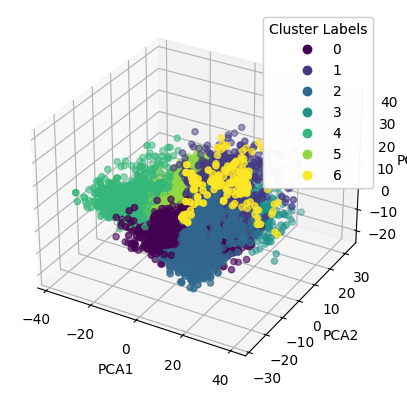

In [38]:
# 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Create a Birch clustering object with 16 clusters and fit to PCA data
birch = Birch(n_clusters=7)
birch.fit(pca_df)

# Create a new 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the PCA data, color-coded by cluster label
scatter = ax.scatter(pca_df['PCA1'], pca_df['PCA2'], pca_df['PCA3'], c=birch.labels_)

# Set x, y, and z axis labels
ax.set_xlabel('PCA1')
ax.set_ylabel('PCA2')
ax.set_zlabel('PCA3')

# Create a legend for the cluster labels
legend = ax.legend(*scatter.legend_elements(), title='Cluster Labels')
ax.add_artist(legend)

# Calculate and print the Silhouette score
print("Silhouette Score for Birch is:", silhouette_score(pca_df[['PCA1','PCA2','PCA3']], birch.labels_))

# Show the plot
plt.show()